In [165]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from Bio.Phylo._io import parse
from Bio.Phylo.BaseTree import Tree as BioTree

from src.utils.tree_utils import get_taxa_names
from src.distribution_analysis.process_tree import get_observed_nodes, get_clade_split_df

In [166]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [167]:
from phylodata import load_experiment
from phylodata import FileType
experiment = load_experiment(
	"tanoyo-2024-systematics-5flw",
	version=2,
	directory=Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/phylodata")
)

In [168]:
methods = {
    "reference": Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/mcmc/yule-50-1.trees"),
    "SB": Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/yule-50-1_Shorter Branch (Gamma) (per partition)_samples.trees"), 
    "HR": Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/yule-50-1_Height (LogNormal) Ratio (Beta) (per partition)_samples.trees"),
}

In [169]:
methods = {
    "reference": experiment.get_file_of_type(FileType.POSTERIOR_TREES).local_path,
    "SB": Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/phylodata-phylodata-tanoyo_2024_systematics_5flwiskandari_beast_run1_Shorter Branch (Gamma) (per partition)_samples.trees"),
    "HR": Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/phylodata-phylodata-tanoyo_2024_systematics_5flwiskandari_beast_run1_Height (LogNormal) Ratio (Beta) (per partition)_samples.trees"),
    "EXPHR": Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/phylodata-phylodata-tanoyo_2024_systematics_5flwiskandari_beast_run1_Height (LogNormal) Ratio (ExpBeta) (per partition)_samples.trees"),
    "HRCP": Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/phylodata-phylodata-tanoyo_2024_systematics_5flwiskandari_beast_run1_Height (LogNormal) Ratio (Beta) Copula (per partition)_samples.trees"),
}

In [170]:
dfs = []

for method, path in methods.items():
    trees: list[BioTree] = list(parse(path, "nexus"))
    taxa_names = get_taxa_names(trees[0])
    
    _, clade_splits = get_observed_nodes(trees, taxa_names)
    df = get_clade_split_df(clade_splits)
    df["method"] = method
    dfs.append(df)

df = pd.concat(dfs)

In [171]:
df["height"] = df["tree_height"] - df["height"]
df["left_height"] = df["height"] - df["left_branch"]
df["right_height"] = df["height"] - df["right_branch"]
df["parent_height"] = df["height"] + df["branch_to_parent"]

### Correlations

In [182]:
CORRELATION_ANALYSES = {
    "1.1. Correlation of Sibling Branches": ["left_branch", "right_branch"],
    "1.2. Correlation of Child Parent Branch": ["branch_to_parent", "left_branch"],
    "1.3. Correlation of Branch and Tree Height": ["branch_to_parent", "tree_height"],
    "1.4. Correlation of Branch and Height": ["branch_to_parent", "height"],
    "2.1. Correlation of Sibling Ratios": ["left_ratio", "right_ratio"],
    "2.2. Correlation of Child Parent Ratio": ["parent_ratio", "ratio"],
    "2.3. Correlation of Ratio and Tree Height": ["ratio", "tree_height"],
    "2.4. Correlation of Ratio and Height": ["ratio", "height"],
    "3.1. Correlation of Sibling Heights": ["left_height", "right_height"],
    "3.2. Correlation of Child Parent Heights": ["parent_height", "height"],
    "3.3. Correlation of Height and Tree Height": ["height", "tree_height"],
}

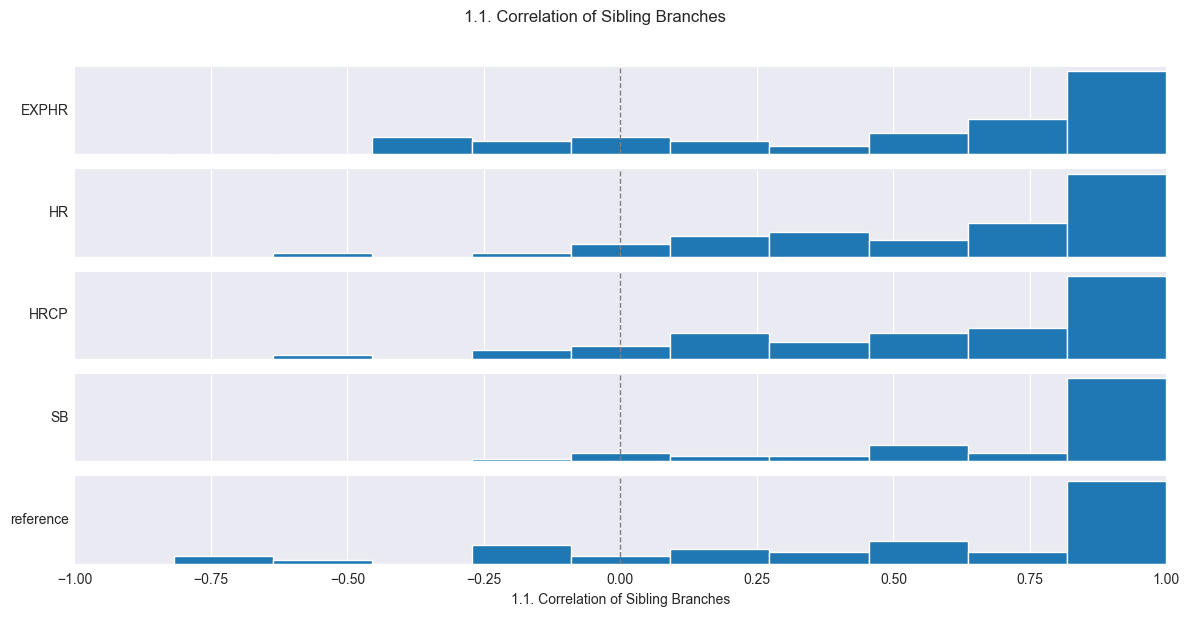

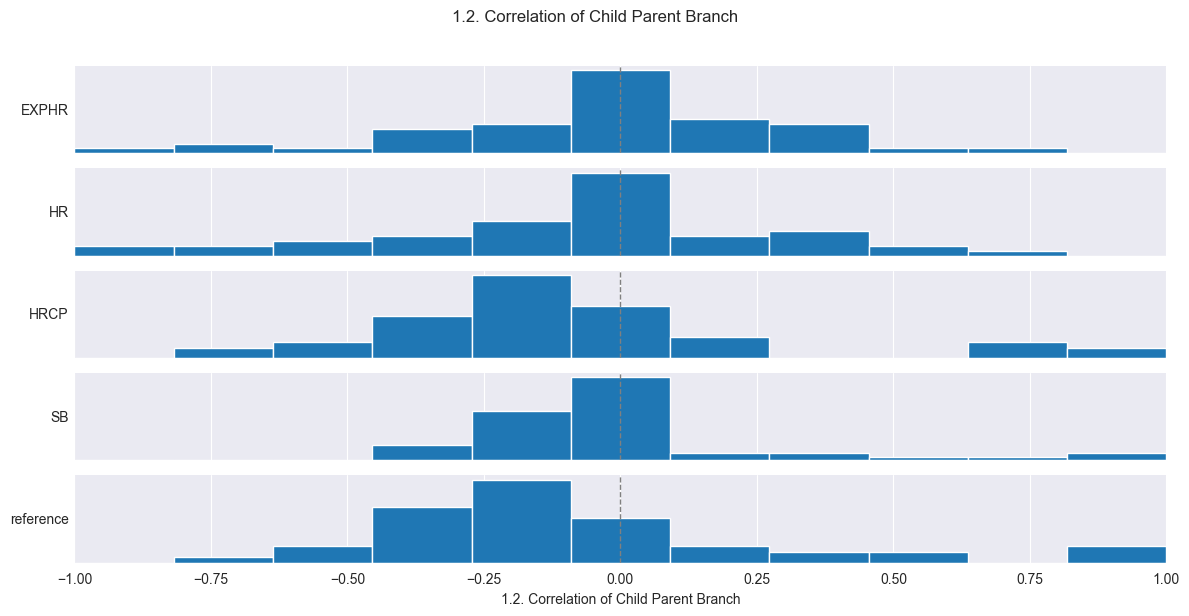

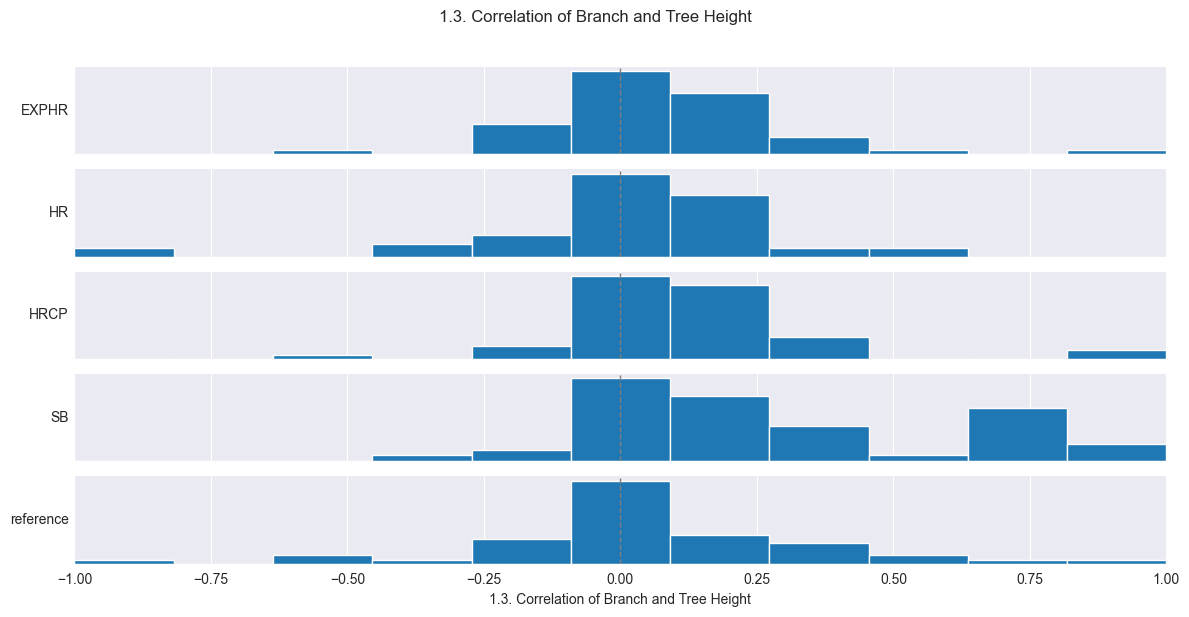

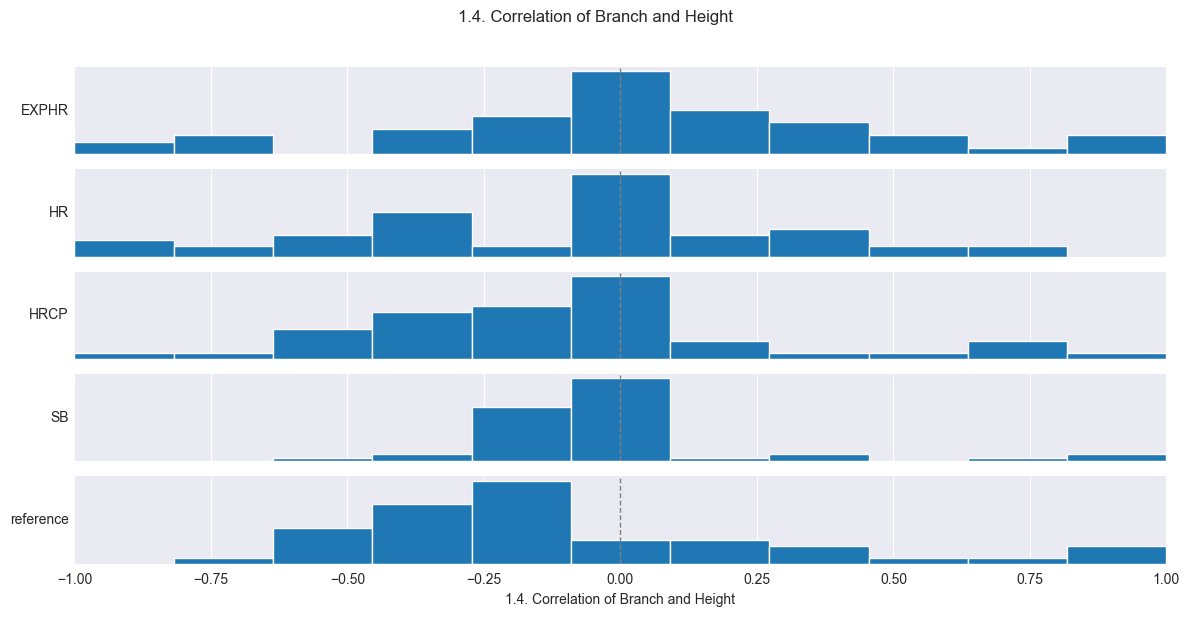

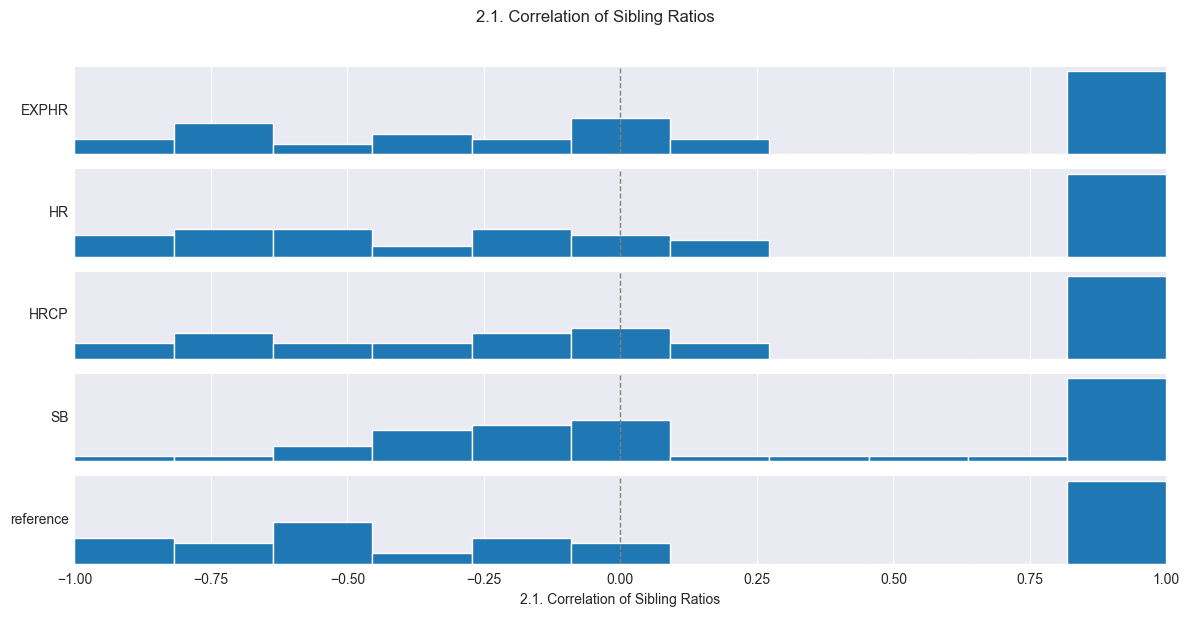

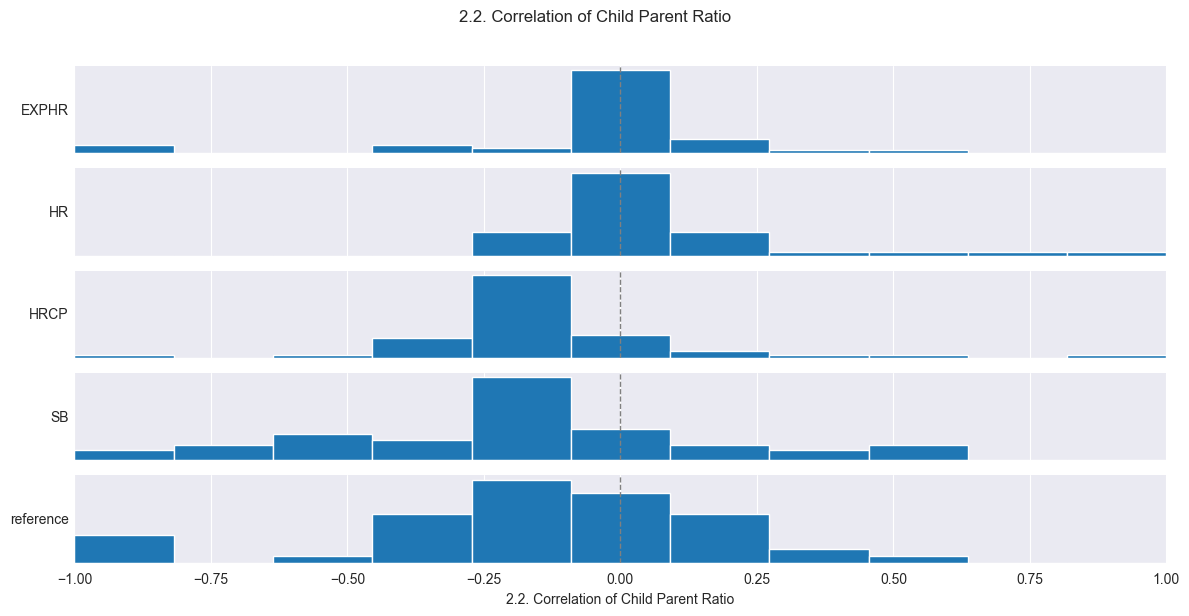

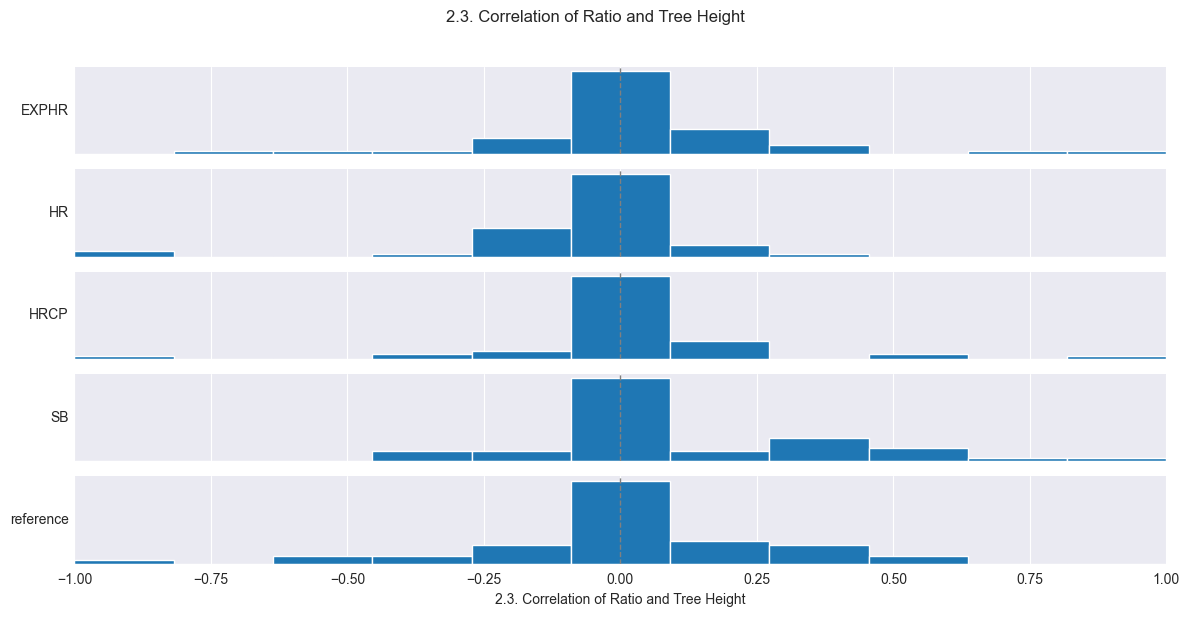

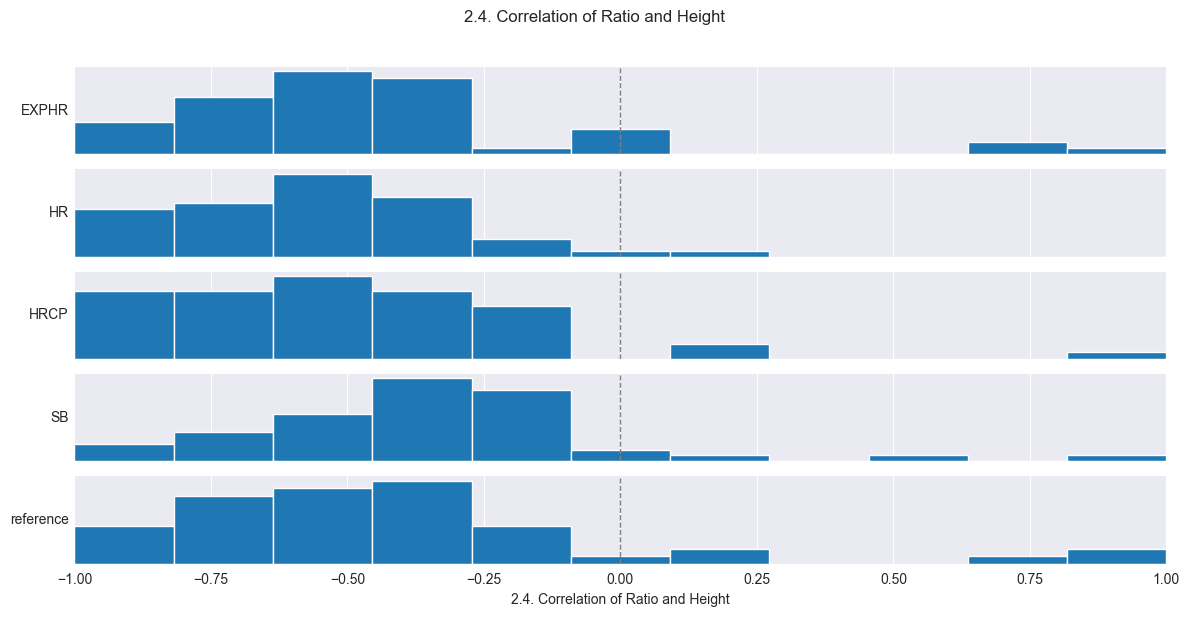

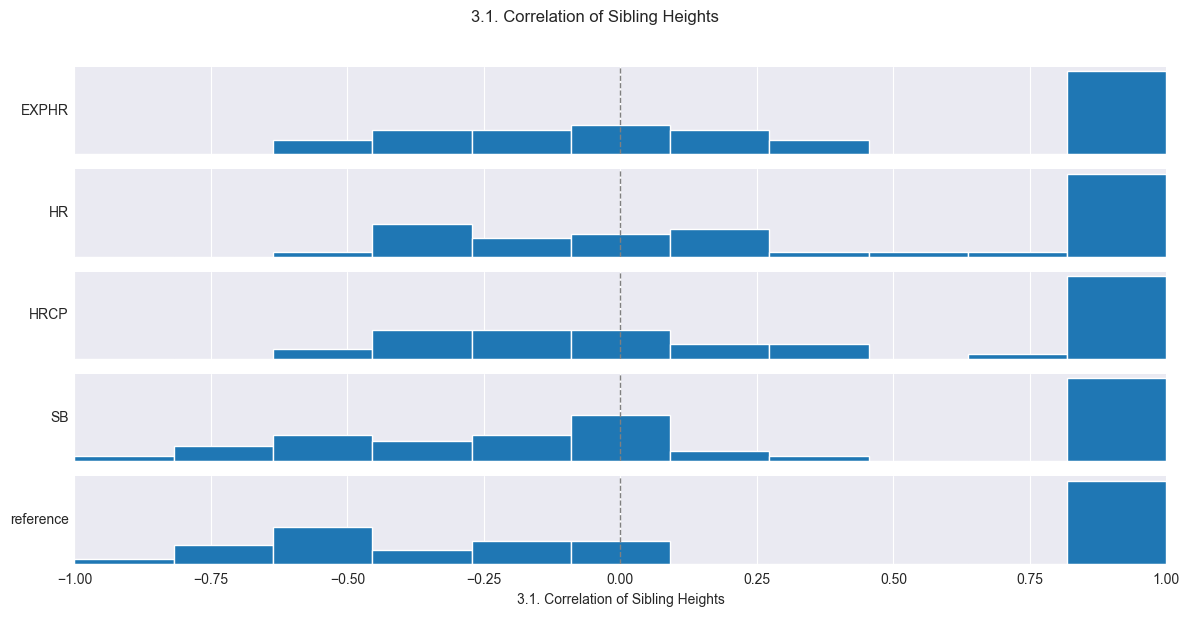

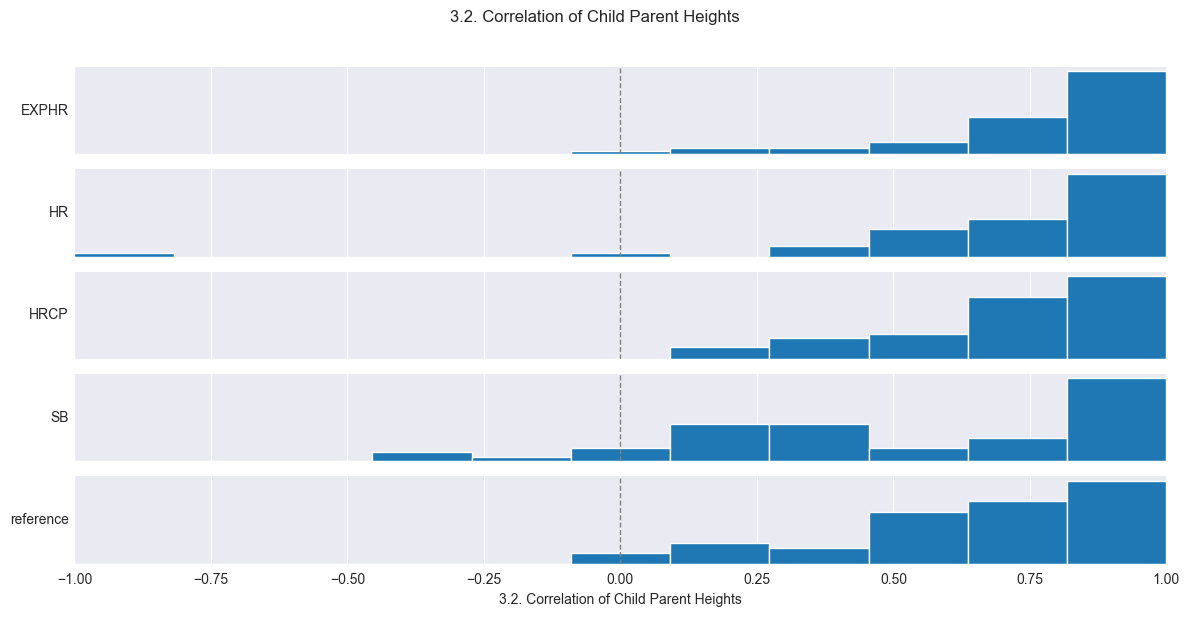

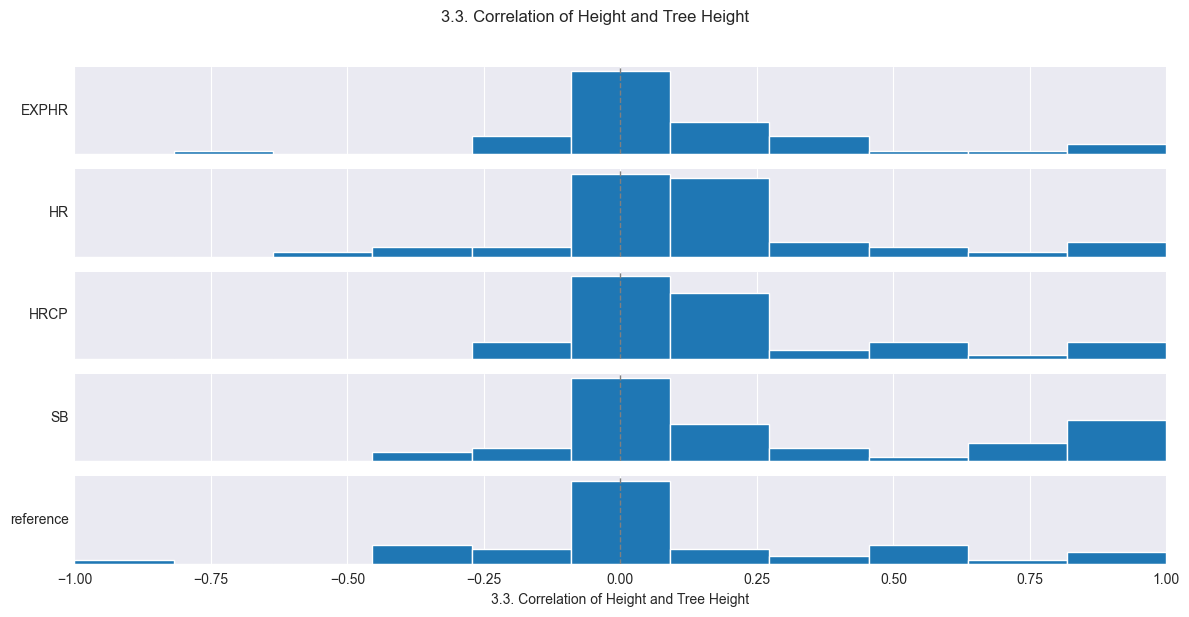

In [183]:
for analysis_name, columns in CORRELATION_ANALYSES.items():
    clade_corrs = []
    for exp_id, group in df.groupby("method"):
        for clade, clade_group in group.groupby("clade"):
            if clade_group[columns].shape[0] > 1:
                corr = clade_group[columns].corr().iloc[0, 1]
            else:
                corr = np.nan
            clade_corrs.append({
                "method": exp_id,
                "clade": clade,
                "corr": corr
            })
    clade_corrs_df = pd.DataFrame(clade_corrs)

    methods = clade_corrs_df["method"].unique()
    n_experiments = len(methods)

    ncols = 1
    nrows = n_experiments

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(12, nrows * 1.2),
        sharex=True,
        constrained_layout=True
    )

    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for idx, (ax, exp_id) in enumerate(zip(axes_flat, methods)):
        data = clade_corrs_df.loc[clade_corrs_df["method"] == exp_id, "corr"].dropna()
        ax.hist(data, bins=np.linspace(-1, 1, 12))
        ax.axvline(0, color='gray', linestyle='--', linewidth=1)  # Add a line for x=0
        ax.set_ylabel(exp_id, rotation=0, ha='right', va='center')
        ax.set_yticks([])
        ax.set_xlim(-1, 1)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    # Set x-label only on the bottom plots
    for ax in axes_flat[-ncols:]:
        ax.set_xlabel(analysis_name)

    plt.suptitle(analysis_name, y=1.02)
    plt.tight_layout()
    plt.show()

### Correlations over time

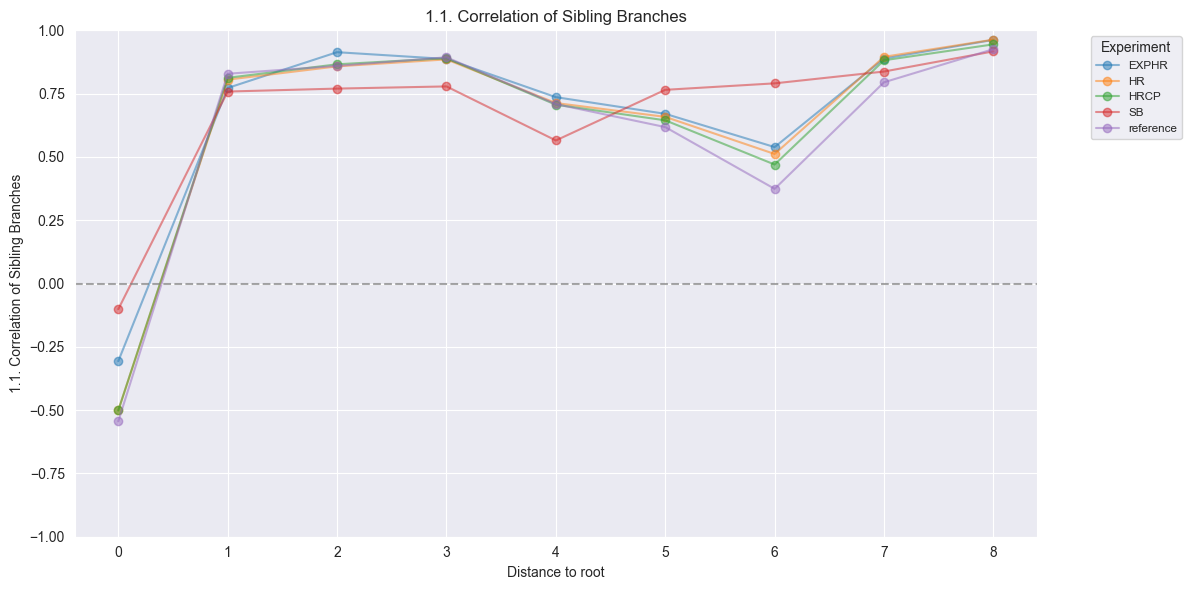

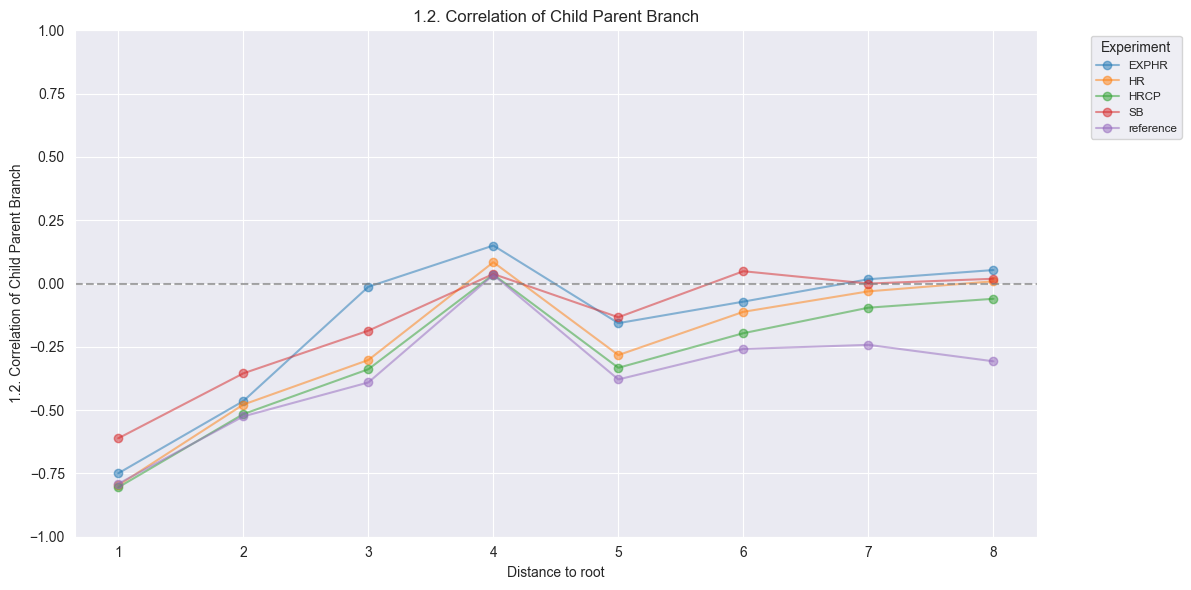

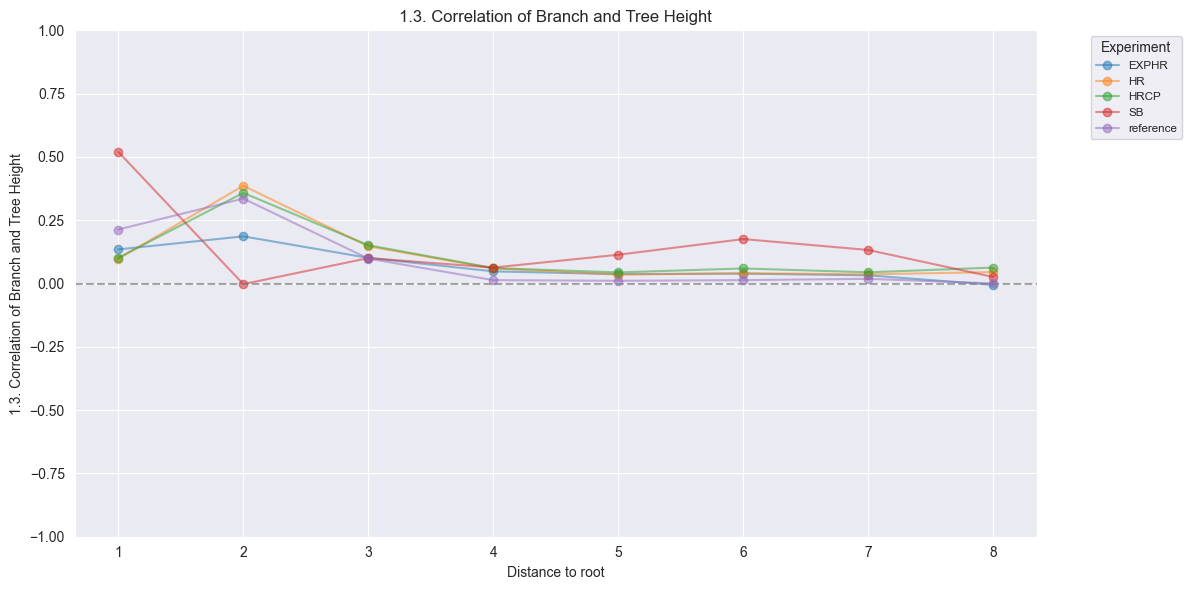

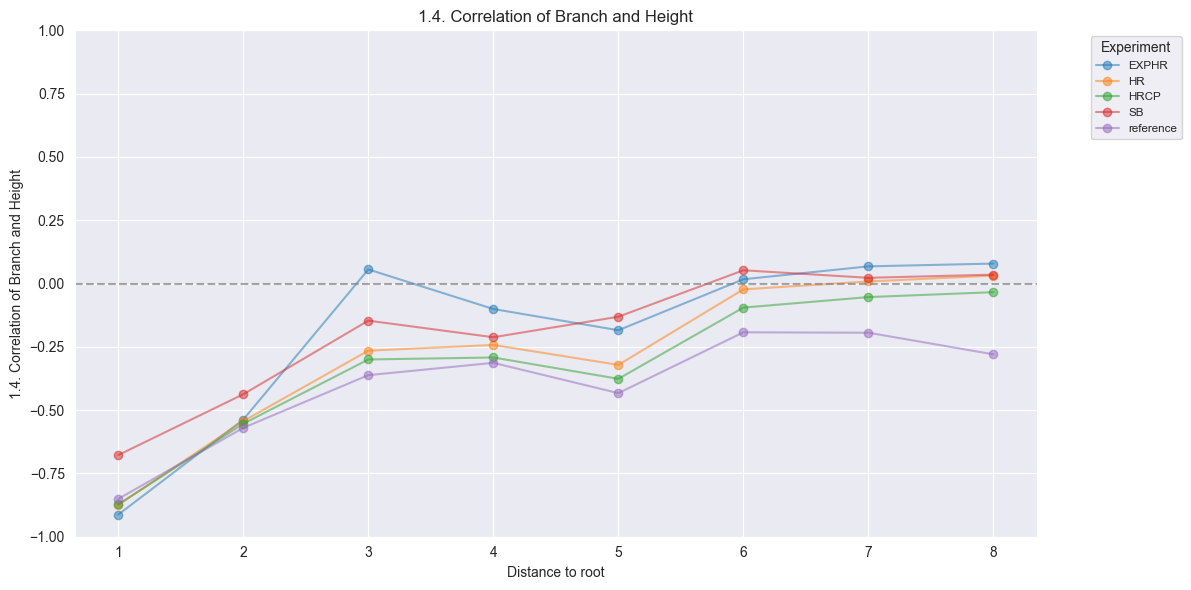

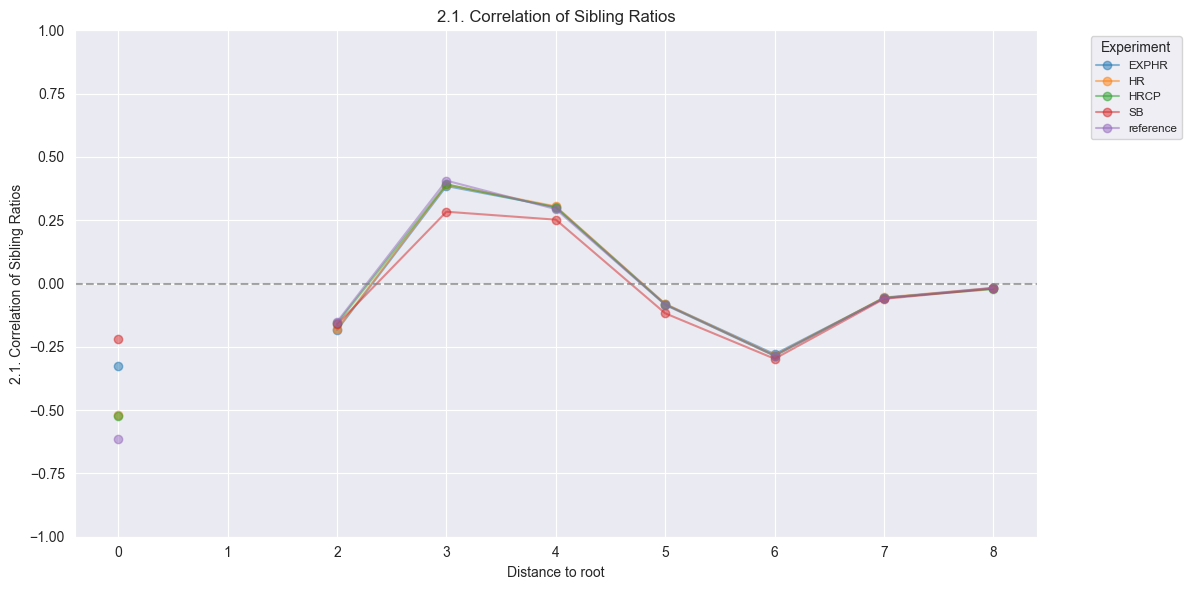

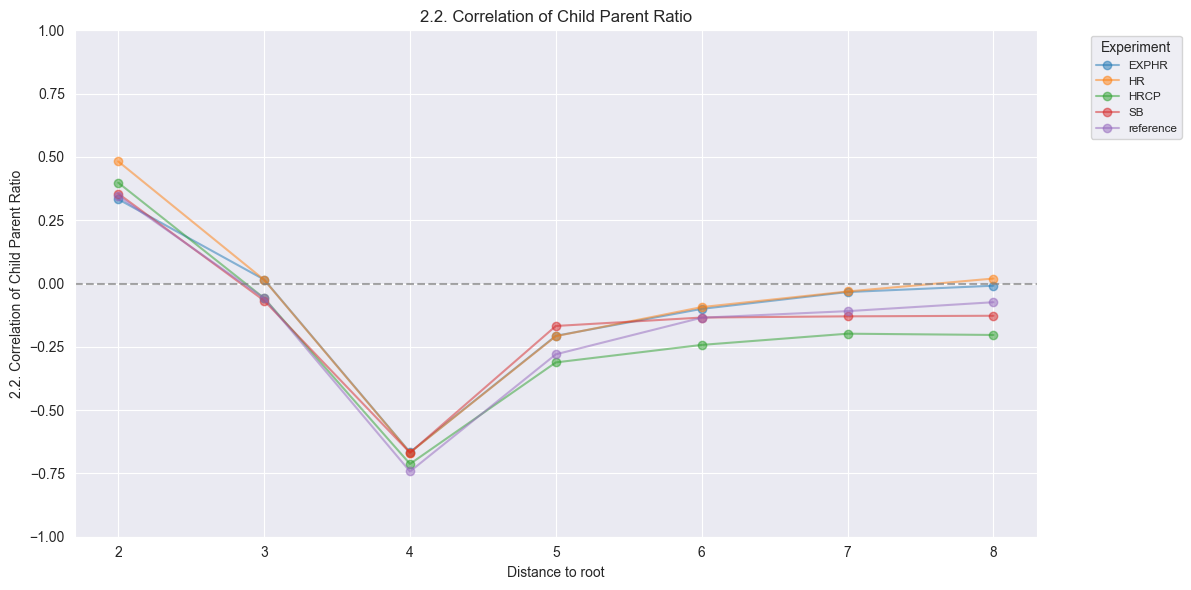

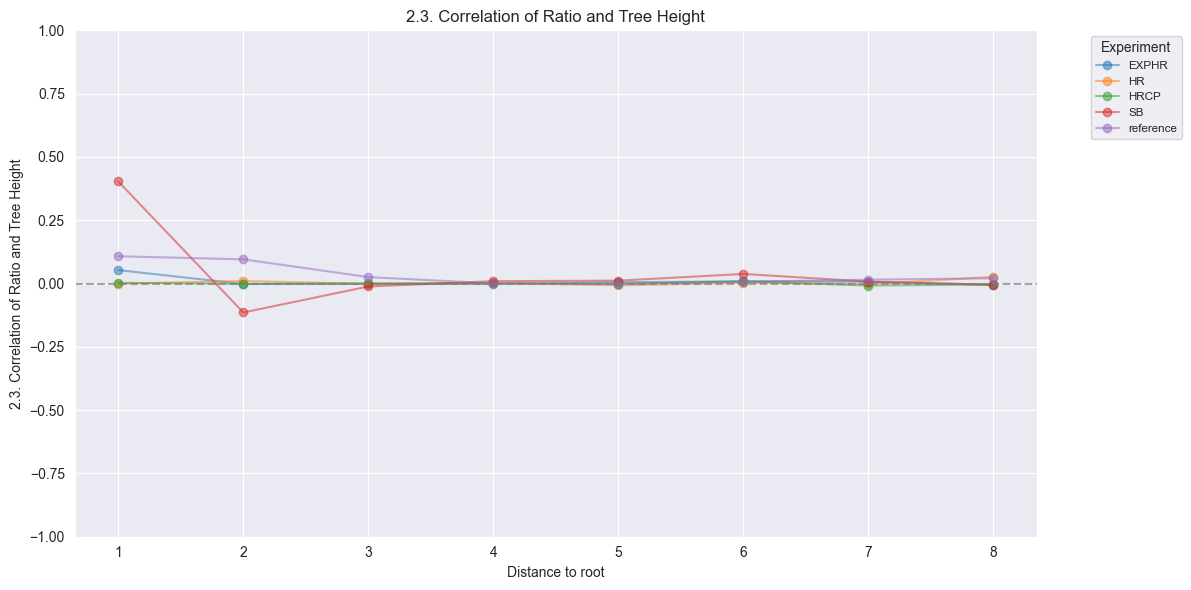

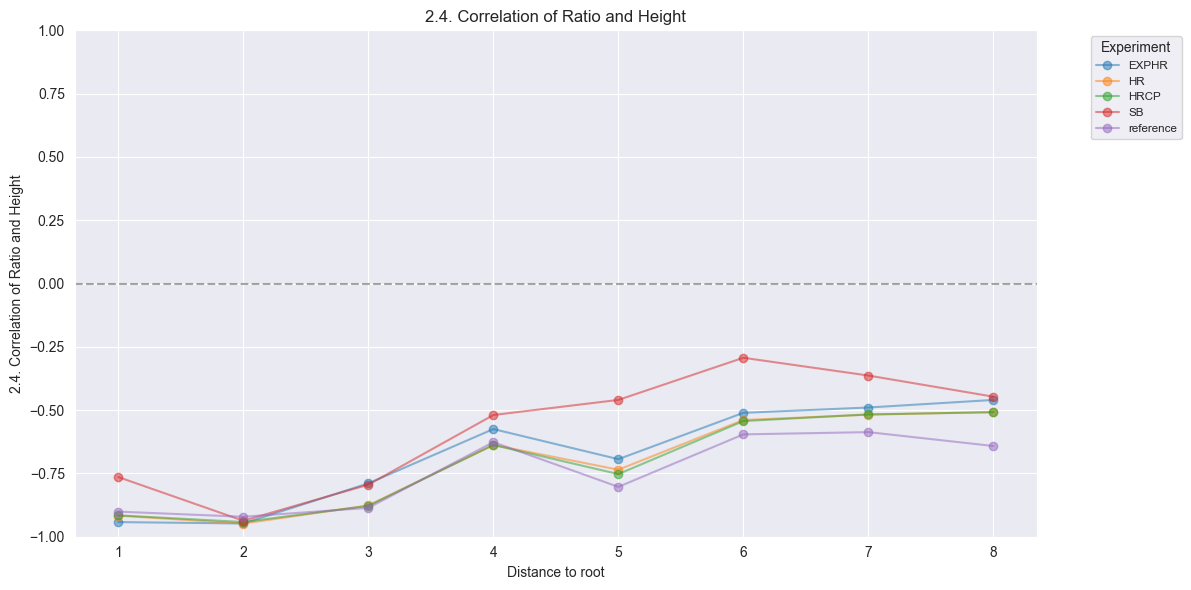

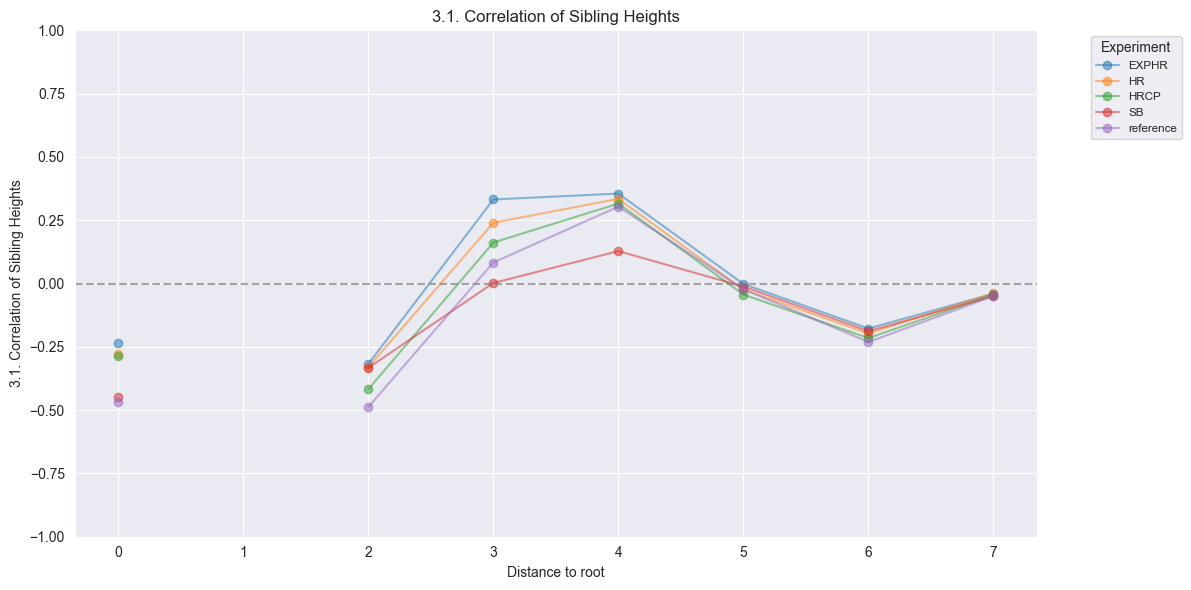

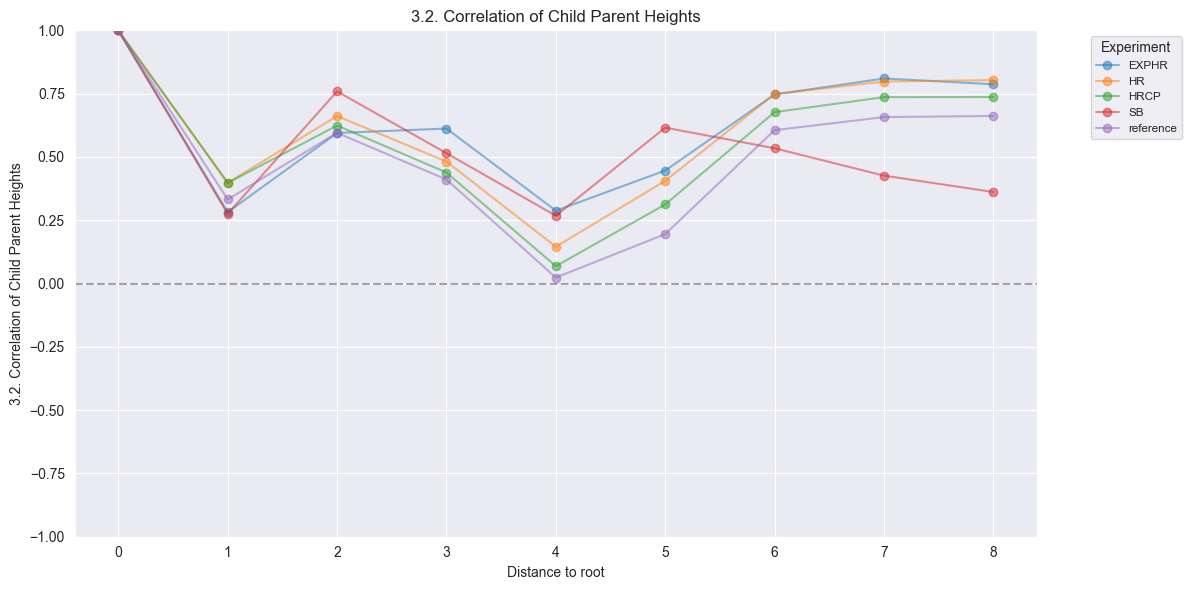

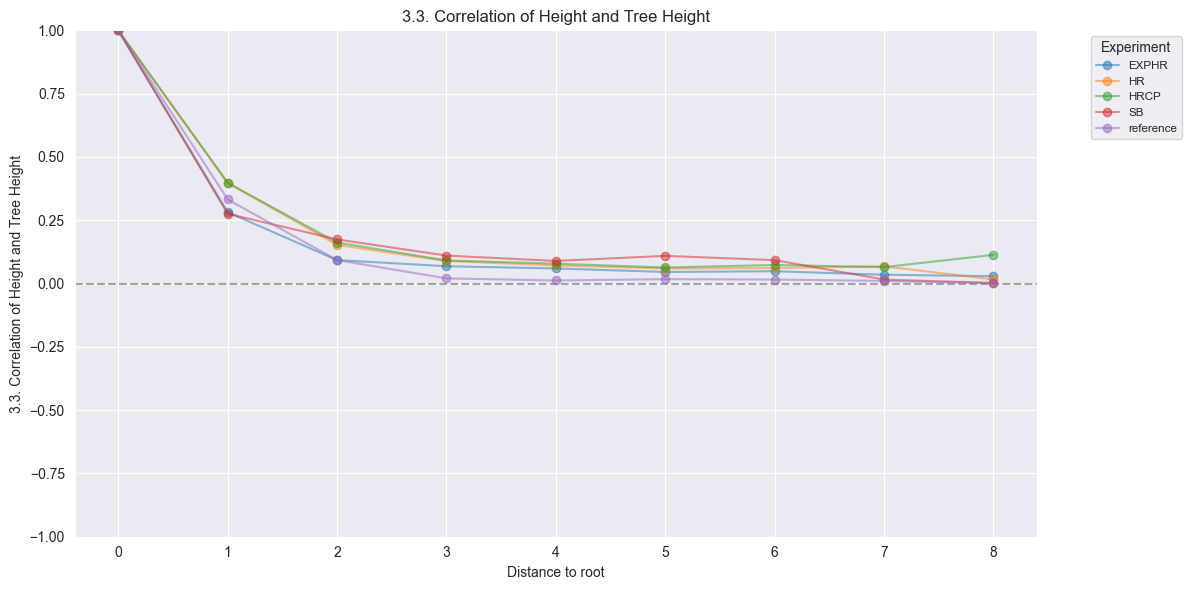

In [188]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

MIN_VALUES_CONSIDERED = 100

for analysis_name, (col_1, col_2) in CORRELATION_ANALYSES.items():
    plt.figure(figsize=(12, 6))

    for exp_id, exp_group in df.groupby("method"):
        distance_vals = np.sort(exp_group["distance_to_root"].unique())
        
        corrs = []
        valid_distances = []
        for dist in distance_vals:
            subset = exp_group[exp_group["distance_to_root"] == dist]
        
            # Only calculate if there are enough values
            if subset[col_1].nunique() > MIN_VALUES_CONSIDERED and subset[col_2].nunique() > MIN_VALUES_CONSIDERED:
                r, _ = pearsonr(subset[col_1], subset[col_2])
                corrs.append(r)
                valid_distances.append(dist)
            else:
                # Not enough data to calculate a correlation
                corrs.append(np.nan)
                valid_distances.append(dist)
        plt.plot(valid_distances, corrs, marker='o', label=exp_id, alpha=0.5)

    plt.xlabel("Distance to root")
    plt.ylabel(analysis_name)
    plt.axhline(0, color='grey', linestyle='--', alpha=0.7)
    plt.ylim(-1, 1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="small", title="Experiment")
    plt.title(analysis_name)
    plt.tight_layout()
    plt.show()


### Height Marginals

In [184]:
MARGINALS = {
    "Tree Height": "tree_height",
    "Node Height": "height",
    "Branch Length": "left_branch",
}

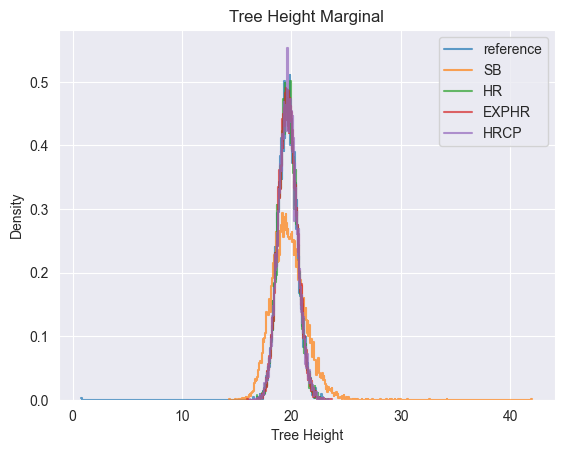

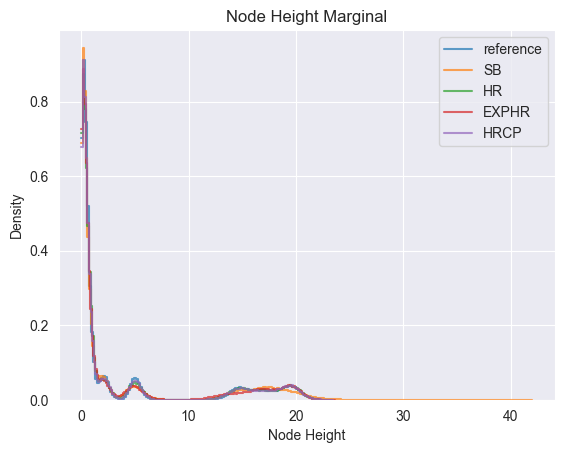

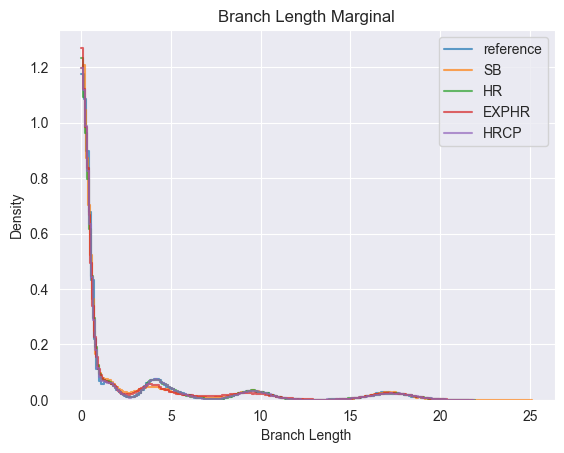

In [185]:
for analysis_name, column in MARGINALS.items():
    for method in df.method.unique():
        sns.histplot(
            data=df[df.method == method],
            x=column,
            stat="density",
            fill=False,
            element="step",
            label=method,
            alpha=0.7
        )

    plt.title(f"{analysis_name} Marginal")
    plt.xlabel(analysis_name)
    plt.legend()
    plt.show()